In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
sns.set(style="whitegrid")

In [23]:
from pyper import R
r = R(use_pandas = True)
print r('require(lme4)')

try({require(lme4)})
Loading required package: lme4
Loading required package: Matrix



In [24]:
def plotMyEffect(a_test, CIs):

    figsize(6, 6)
    mpl.rcParams['font.size']=22

    fig, ax = plt.subplots(1)
    #ax.margins(0.05)

    spines_to_remove = ['top', 'right']

    for spine in spines_to_remove:
        ax.spines[spine].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    d = a_test.reset_index()
    first = len(pd.Series(d.ix[:,0].values).unique())
    second = len(pd.Series(d.ix[:,1].values).unique())
    try:
        third = len(pd.Series(d.ix[:,2].values).unique())
    except IndexError:
        third = 0

    colors = ['#b2df8a']*second
    colors.extend(['#a6cee3']*second)
    colors.extend(['#1c9099']*second)
    colors.extend(['#ffc676']*second)

    #colors = ['#b2df8a','#b2df8a','#a6cee3','#a6cee3','#1c9099','#1c9099']
    #colors = ['#fb9a99','#fb9a99','lightgray','lightgray']

    tick_params(labelsize=18)
    ylabel(a_test.name, fontsize=22) #ind = np.arange(N)    # the x locations for the groups
    
    #colors = ['#fb9a99','#fb9a99','lightgray','lightgray']
    a_test.plot(kind='bar',grid=False, yerr=CIs,color=colors,ecolor='#262626',ax=ax)
    ##print a_test
    
    ax.set_xlim(-1, len(a_test))
    plt.show()

In [25]:
def withinSubCIs(a,DV):

    ## Get subject average
    by_sub = a.groupby('subject')[DV].mean().reset_index()
    
    ## Get group grand mean
    group_mean = by_sub[DV].mean()
    
    ## Rename sub average of DV
    by_sub = by_sub.rename(columns={DV:'subAvg'})

    ## Create DF with normalized DV values
    j = a.merge(by_sub,on='subject')
    j['groupAvg'] = group_mean
    j['DV_norm'] = j[DV] - j.subAvg + j.groupAvg
    
    ## Find IVs from input DF
    IVs = [item for item in list(j.columns) if item not in ['subject','subAvg','groupAvg','DV_norm',DV]]

    ## Group DF across subjects by IVs to get standard deviation by condition
    conditions_norm = j.groupby(IVs)['DV_norm'].std().reset_index()

    ## Find SE, Morey (2008) correction and t-value, and CIs
    conditions_norm['se'] = conditions_norm.DV_norm/np.sqrt(by_sub.shape[0])
    conditions_norm['correction'] = np.sqrt(float(conditions_norm.shape[0])/(float(conditions_norm.shape[0]) - 1))
    conditions_norm['t_val'] = stats.t.ppf(1 - 0.025, by_sub.shape[0] -1)
    conditions_norm['CI'] = conditions_norm.se*conditions_norm.t_val*conditions_norm.correction
    
    return list(conditions_norm['CI'])

In [26]:
def formatMyEffect(in_df,DV,in_list):
    g = in_df.groupby(in_list)
    a = g[DV].mean()
    a = a.reset_index()
    
    CIs = withinSubCIs(a,DV)
    print "CIs:",' '.join([str(item) for item in CIs])
    
    ## Get condtion means
    in_list = [item for item in in_list if item != 'subject']
        
    c = a.groupby(in_list)
    m = c[DV].mean()
    a_test = m
    
    return a_test, CIs

In [27]:
data_path = 'data/'
infiles = [item for item in os.listdir(data_path) if item.endswith('txt')]

In [28]:
#since s020 stopped and restarted, there were two files, which have already been combined in 's020_output_0.txt'
infiles = [item for item in infiles if item != 's020_output_2.txt'] 


In [29]:
infiles

['s002_output.txt',
 's003_output_0.txt',
 's004_output_0.txt',
 's005_output_0.txt',
 's006_output_0.txt',
 's007_output_0.txt',
 's008_output_0.txt',
 's009_output_0.txt',
 's010_output_0.txt',
 's011_output_0.txt',
 's012_output_0.txt',
 's013_output_0.txt',
 's014_output_0.txt',
 's015_output_0.txt',
 's016_output_0.txt',
 's017_output_0.txt',
 's018_output_0.txt',
 's019_output_0.txt',
 's020_output_0.txt',
 's021_output_0.txt',
 's022_output_0.txt',
 's023_output_0.txt',
 's024_output_0.txt',
 's025_output_0.txt',
 's026_output_0.txt',
 's027_output_0.txt',
 's028_output_0.txt']

In [30]:
columns = ['trial_num','cue_type','target_identity','target_category','choices','target_presence',
           'response','response_correct','response_time','total_trial_time',
           'precue_value','IDUNNOpre1','IDUNNOpre2','precue_time','precue_time_actual','precue_position',
           'picture1_value','IDUNNO1','picture1_stim','picture1_time','picture1_time_actual', 'picture1_posititon',
           'picture2_value','IDUNNO2','picture2_stim','picture2_time','picture2_time_actual', 'picture2_posititon',
           'picture3_value','IDUNNO3','picture3_stim','picture3_time','picture3_time_actual', 'picture3_posititon',
           'picture4_value','IDUNNO4','picture4_stim','picture4_time','picture4_time_actual', 'picture4_posititon',
           'picture5_value','IDUNNO5','picture5_stim','picture5_time','picture5_time_actual', 'picture5_posititon',
           'picture6_value','IDUNNO6','picture6_stim','picture6_time','picture6_time_actual', 'picture6_posititon',
            'postcue_value','IDUNNOpost1','IDUNNOpost2','postcue_time','postcue_time_actual','postcue_position']
           

In [31]:
df_all = []
for infile in infiles:
    subject =  infile[:4]
    if subject not in  ['s002','s008','s019']: #s002 is ok, just not the same format
        df = pd.read_csv(data_path+infile, sep="\t", header = None)
        df.columns = columns
        df['subject'] = subject
        df_all.append(df)
    elif subject == 's002':
        df2 = pd.read_csv(data_path+infile, sep="\t")
        df2['subject'] = subject
        
df2.columns = columns+['subject']
df_all.append(df2)


In [32]:
result = pd.concat(df_all)

In [33]:
result = result.reset_index(drop=True)

In [34]:
result.tail(15)

,trial_num,cue_type,target_identity,target_category,choices,target_presence,response,response_correct,response_time,total_trial_time,...,picture6_time,picture6_time_actual,picture6_posititon,postcue_value,IDUNNOpost1,IDUNNOpost2,postcue_time,postcue_time_actual,postcue_position,subject
11937,413,precue,chair,object,"['a', 'b']",present,present,1,0.235943,6.548302,...,0.1,0.116472,"[(0, 0)]",[False],['present'],[False],0.9,0.900004,"[(0, 0)]",s002
11938,414,postcue,flower,object,"['a', 'b']",present,absent,0,0.426396,6.581963,...,0.1,0.116658,"[(0, 0)]",['flower'],['absent'],['flower'],0.9,0.916633,"[(0, 0)]",s002
11939,415,precue,coast,scene,"['a', 'b']",absent,absent,1,0.222983,6.581387,...,0.1,0.100046,"[(0, 0)]",[False],['absent'],[False],0.9,0.916645,"[(0, 0)]",s002
11940,416,nocue,FALSE,FALSE,"['a', 'b']",absent,present,0,0.405603,6.548283,...,0.1,0.116591,"[(0, 0)]",[False],['present'],[False],0.9,0.916659,"[(0, 0)]",s002
11941,417,precue,bathroom,scene,"['a', 'b']",present,present,1,0.242355,6.548312,...,0.1,0.100039,"[(0, 0)]",[False],['present'],[False],0.9,0.900046,"[(0, 0)]",s002
11942,418,precue,flower,object,"['a', 'b']",present,present,1,0.234954,6.548464,...,0.1,0.116562,"[(0, 0)]",[False],['present'],[False],0.9,0.900038,"[(0, 0)]",s002
11943,419,postcue,desert,scene,"['a', 'b']",absent,absent,1,0.421976,6.548316,...,0.1,0.116470,"[(0, 0)]",['desert'],['absent'],['desert'],0.9,0.916649,"[(0, 0)]",s002
11944,420,doublecue,"('shoe', 'bathroom')","('object', 'scene')","['a', 'b']","('present', 'present')",present,0,0.851407,6.564967,...,0.1,0.116664,"[(0, 0)]",['bathroom'],['present'],['bathroom'],0.9,0.916646,"[(0, 0)]",s002
11945,421,precue,shoe,object,"['a', 'b']",absent,absent,1,0.196185,6.514988,...,0.1,0.100031,"[(0, 0)]",[False],['absent'],[False],0.9,0.900033,"[(0, 0)]",s002
11946,422,postcue,flower,object,"['a', 'b']",absent,present,0,0.237437,6.548337,...,0.1,0.116684,"[(0, 0)]",['flower'],['present'],['flower'],0.9,0.900045,"[(0, 0)]",s002


In [35]:
h = result[(result.cue_type != 'nocue') & (result.cue_type != 'doublecue')].groupby(
    ['subject'])['response_correct'].mean().reset_index()

In [36]:
h

,subject,response_correct
0,s002,0.754045
1,s003,0.721831
2,s004,0.713911
3,s005,0.719880
4,s006,0.783854
5,s007,0.710938
6,s009,0.674479
7,s010,0.763021
8,s011,0.713542
9,s012,0.747396


In [37]:
result.loc[((result.target_presence=='present') & (result.response=='present')),'hit'] = 1
result.loc[((result.target_presence=='present') & (result.response=='absent')),'hit'] = 0
result.loc[((result.target_presence=='absent') & (result.response=='absent')),'fa'] = 0
result.loc[((result.target_presence=='absent') & (result.response=='present')),'fa'] = 1

result.loc[((result.target_presence=='present') & (result.response=='present')),'miss'] = 0
result.loc[((result.target_presence=='present') & (result.response=='absent')),'miss'] = 1
result.loc[((result.target_presence=='absent') & (result.response=='absent')),'corr_reject'] = 1
result.loc[((result.target_presence=='absent') & (result.response=='present')),'corr_reject'] = 0

In [38]:
#d' = z(H) - z(F)

In [39]:
h = result[(result.cue_type != 'nocue') & (result.cue_type != 'doublecue')].groupby(
    ['subject','cue_type'])[['hit','fa']].mean().reset_index()

In [40]:
h['dprime'] = 0.5*np.log((1+h.hit)/(1-h.hit)) - 0.5*np.log((1+h.fa)/(1-h.fa))

In [41]:
h

,subject,cue_type,hit,fa,dprime
0,s002,postcue,0.687500,0.369863,0.454935
1,s002,precue,0.782051,0.065789,0.984746
2,s003,postcue,0.361111,0.108108,0.269631
3,s003,precue,0.695652,0.029851,0.828966
4,s004,postcue,0.608696,0.244681,0.457100
5,s004,precue,0.788235,0.170213,0.894869
6,s005,postcue,0.558442,0.146341,0.483166
7,s005,precue,0.614458,0.085366,0.630478
8,s006,postcue,0.557895,0.145833,0.482891
9,s006,precue,0.776596,0.010638,1.026097


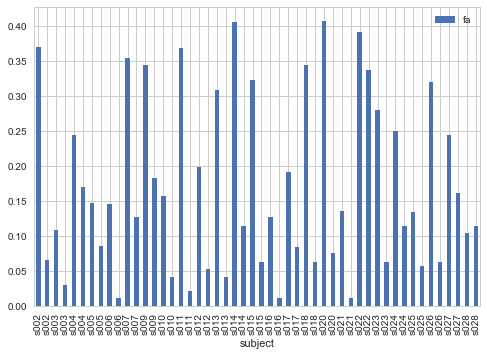

In [42]:
h.plot('subject','fa',kind='bar')

--------------------------------------------------------------
Average fa(SD) for cue_type:
postcue	25.59 (10.4)
precue	8.63 (7.14)
--------------------------------------------------------------
CIs: 0.0291946124107 0.0291946124107


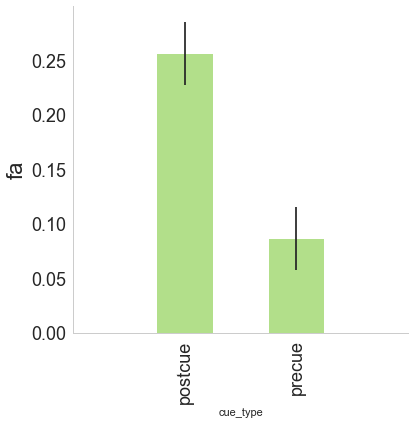

In [43]:
# Define variables 
df_graph = h
dataVar = 'fa'
iv1 = 'cue_type'

#Average across subjects by IV 1
g = df_graph.groupby(['subject',iv1])
a = g[dataVar].mean() #means etc by subject
a = a.reset_index()

print "--------------------------------------------------------------"
print 'Average '+dataVar+'(SD) for '+iv1+':'
c = a.groupby([iv1])
m = c[dataVar].mean().reset_index()
s = c[dataVar].std().reset_index()

for i,row in m.iterrows():
    print  m.loc[i][iv1]+'\t', np.round(m.loc[i][dataVar],4)*100,"("+str(np.round(s.loc[i][dataVar],4)*100)+")"
print "--------------------------------------------------------------"


b, CIs = formatMyEffect(df_graph,dataVar,['subject',iv1])
plotMyEffect(b, CIs)

In [45]:
## 1-way anove (condA: A, B) repeated measure ANOVA

# Get data into R
r.r_data = a
print r('head(r_data)')

# Run ANOVA using R syntax with string variable defined above
r('anova <- aov('+dataVar+' ~ '+iv1+' + Error(subject/'+iv1+'), data=r_data)')
r('myModelSummary <- summary(anova)')
print r('summary(anova)')

# IV 1 info
dfs_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Df'")
fval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'F value'")
pval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Pr(>F)'")

fval_iv1 = np.round(fval_iv1[0],2)
pval_iv1 = np.round(pval_iv1[0],4)

# Eta square for IV 1
sumSq = float(r('summary(anova)[2][[1]][[1]][[2]][1]').split('[1] ')[1])
residualsSumSq = float(r('summary(anova)[2][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_iv1 = np.round(sumSq/(sumSq+residualsSumSq),2)


print "--------------------------------------------------------------"
print "\nEffect of",iv1,"on",dataVar
print "F("+str(dfs_iv1[0])+","+str(dfs_iv1[1])+") =",fval_iv1,", p =",pval_iv1,", partial η2 =",etaSquare_iv1
print "\b"
print "--------------------------------------------------------------"

try({head(r_data)})
  subject cue_type         fa
0    s002  postcue 0.36986301
1    s002   precue 0.06578947
2    s003  postcue 0.10810811
3    s003   precue 0.02985075
4    s004  postcue 0.24468085
5    s004   precue 0.17021277

try({summary(anova)})

Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 24 0.2616  0.0109               

Error: subject:cue_type
          Df Sum Sq Mean Sq F value   Pr(>F)    
cue_type   1 0.3598  0.3598   71.93 1.11e-08 ***
Residuals 24 0.1201  0.0050                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

0.3598041 0.1200549 0.75
--------------------------------------------------------------

Effect of cue_type on fa
F(1,24) = 71.93 , p = 0.0 , partial η2 = 0.75

--------------------------------------------------------------


--------------------------------------------------------------
Average response_correct(SD) for cue_type:
postcue	63.88 (4.15)
precue	79.85 (6.29)
--------------------------------------------------------------
CIs: 0.0156980310958 0.0156980310958


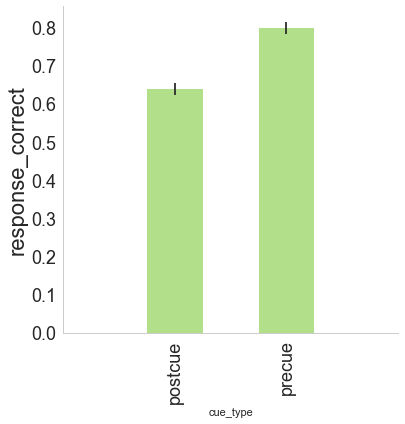

In [59]:
# Define variables 
df_graph = result[(result.cue_type != 'nocue') & (result.cue_type != 'doublecue')]
dataVar = 'response_correct'
iv1 = 'cue_type'

#Average across subjects by IV 1
g = df_graph.groupby(['subject',iv1])
a = g[dataVar].mean() #means etc by subject
a = a.reset_index()

print "--------------------------------------------------------------"
print 'Average '+dataVar+'(SD) for '+iv1+':'
c = a.groupby([iv1])
m = c[dataVar].mean().reset_index()
s = c[dataVar].std().reset_index()

for i,row in m.iterrows():
    print  m.loc[i][iv1]+'\t', np.round(m.loc[i][dataVar],4)*100,"("+str(np.round(s.loc[i][dataVar],4)*100)+")"
print "--------------------------------------------------------------"


b, CIs = formatMyEffect(df_graph,dataVar,['subject',iv1])
plotMyEffect(b, CIs)

In [60]:
## 1-way anove (condA: A, B) repeated measure ANOVA

# Get data into R
r.r_data = a
print r('head(r_data)')

# Run ANOVA using R syntax with string variable defined above
r('anova <- aov('+dataVar+' ~ '+iv1+' + Error(subject/'+iv1+'), data=r_data)')
r('myModelSummary <- summary(anova)')
print r('summary(anova)')

# IV 1 info
dfs_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Df'")
fval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'F value'")
pval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Pr(>F)'")

fval_iv1 = np.round(fval_iv1[0],2)
pval_iv1 = np.round(pval_iv1[0],4)

# Eta square for IV 1
sumSq = float(r('summary(anova)[2][[1]][[1]][[2]][1]').split('[1] ')[1])
residualsSumSq = float(r('summary(anova)[2][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_iv1 = np.round(sumSq/(sumSq+residualsSumSq),2)


print "--------------------------------------------------------------"
print "\nEffect of",iv1,"on",dataVar
print "F("+str(dfs_iv1[0])+","+str(dfs_iv1[1])+") =",fval_iv1,", p =",pval_iv1,", partial η2 =",etaSquare_iv1
print "\b"
print "--------------------------------------------------------------"

try({head(r_data)})
  subject cue_type response_correct
0    s002  postcue        0.6601307
1    s002   precue        0.8461538
2    s003  postcue        0.6301370
3    s003   precue        0.8188406
4    s004  postcue        0.6649215
5    s004   precue        0.7631579

try({summary(anova)})

Error: subject
          Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 24 0.1014 0.004226               

Error: subject:cue_type
          Df Sum Sq Mean Sq F value   Pr(>F)    
cue_type   1 0.3187  0.3187   220.3 1.36e-13 ***
Residuals 24 0.0347  0.0014                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

--------------------------------------------------------------

Effect of cue_type on response_correct
F(1,24) = 220.34 , p = 0.0 , partial η2 = 0.9

--------------------------------------------------------------


--------------------------------------------------------------
Average response_correct(SD) for target_presence:
absent	81.49 (7.97)
present	62.22 (8.23)
--------------------------------------------------------------
CIs: 0.038913388167 0.038913388167


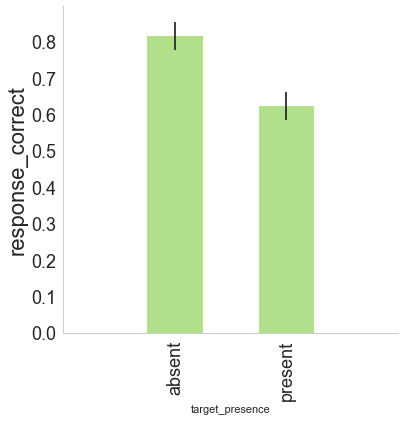

In [61]:
# Define variables 
df_graph = result[(result.cue_type != 'nocue') & (result.cue_type != 'doublecue')]
dataVar = 'response_correct'
iv1 = 'target_presence'

#Average across subjects by IV 1
g = df_graph.groupby(['subject',iv1])
a = g[dataVar].mean() #means etc by subject
a = a.reset_index()

print "--------------------------------------------------------------"
print 'Average '+dataVar+'(SD) for '+iv1+':'
c = a.groupby([iv1])
m = c[dataVar].mean().reset_index()
s = c[dataVar].std().reset_index()

for i,row in m.iterrows():
    print  m.loc[i][iv1]+'\t', np.round(m.loc[i][dataVar],4)*100,"("+str(np.round(s.loc[i][dataVar],4)*100)+")"
print "--------------------------------------------------------------"


b, CIs = formatMyEffect(df_graph,dataVar,['subject',iv1])
plotMyEffect(b, CIs)

In [62]:
## 1-way anove (condA: A, B) repeated measure ANOVA

# Get data into R
r.r_data = a
print r('head(r_data)')

# Run ANOVA using R syntax with string variable defined above
r('anova <- aov('+dataVar+' ~ '+iv1+' + Error(subject/'+iv1+'), data=r_data)')
r('myModelSummary <- summary(anova)')
print r('summary(anova)')

# IV 1 info
dfs_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Df'")
fval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'F value'")
pval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Pr(>F)'")

fval_iv1 = np.round(fval_iv1[0],2)
pval_iv1 = np.round(pval_iv1[0],4)

# Eta square for IV 1
sumSq = float(r('summary(anova)[2][[1]][[1]][[2]][1]').split('[1] ')[1])
residualsSumSq = float(r('summary(anova)[2][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_iv1 = np.round(sumSq/(sumSq+residualsSumSq),2)


print "--------------------------------------------------------------"
print "\nEffect of",iv1,"on",dataVar
print "F("+str(dfs_iv1[0])+","+str(dfs_iv1[1])+") =",fval_iv1,", p =",pval_iv1,", partial η2 =",etaSquare_iv1
print "\b"
print "--------------------------------------------------------------"

try({head(r_data)})
  subject target_presence response_correct
0    s002          absent        0.7800000
1    s002         present        0.7295597
2    s003          absent        0.9225352
3    s003         present        0.5211268
4    s004          absent        0.7842105
5    s004         present        0.6439791

try({summary(anova)})

Error: subject
          Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 24 0.1016 0.004234               

Error: subject:target_presence
                Df Sum Sq Mean Sq F value   Pr(>F)    
target_presence  1 0.4639  0.4639   52.19 1.83e-07 ***
Residuals       24 0.2133  0.0089                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

--------------------------------------------------------------

Effect of target_presence on response_correct
F(1,24) = 52.19 , p = 0.0 , partial η2 = 0.69

--------------------------------------------------------------


--------------------------------------------------------------
Average response_correct(SD) for cue_type:
postcue	63.88 (4.15)
precue	79.85 (6.29)
--------------------------------------------------------------
CIs: 0.0156980310958 0.0156980310958


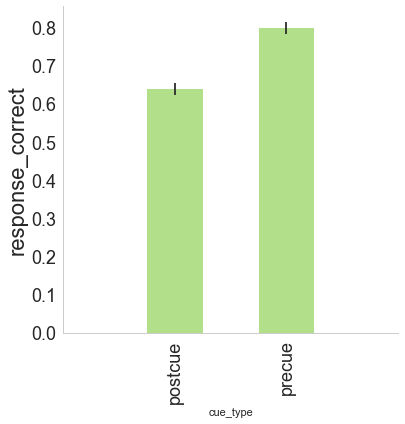

In [63]:
# Define variables 
df_graph = result[(result.cue_type != 'nocue') & (result.cue_type != 'doublecue')]
dataVar = 'response_correct'
iv1 = 'cue_type'

#Average across subjects by IV 1
g = df_graph.groupby(['subject',iv1])
a = g[dataVar].mean() #means etc by subject
a = a.reset_index()

print "--------------------------------------------------------------"
print 'Average '+dataVar+'(SD) for '+iv1+':'
c = a.groupby([iv1])
m = c[dataVar].mean().reset_index()
s = c[dataVar].std().reset_index()

for i,row in m.iterrows():
    print  m.loc[i][iv1]+'\t', np.round(m.loc[i][dataVar],4)*100,"("+str(np.round(s.loc[i][dataVar],4)*100)+")"
print "--------------------------------------------------------------"


b, CIs = formatMyEffect(df_graph,dataVar,['subject',iv1])
plotMyEffect(b, CIs)

In [64]:
## 1-way anove (condA: A, B) repeated measure ANOVA

# Get data into R
r.r_data = a
print r('head(r_data)')

# Run ANOVA using R syntax with string variable defined above
r('anova <- aov('+dataVar+' ~ '+iv1+' + Error(subject/'+iv1+'), data=r_data)')
r('myModelSummary <- summary(anova)')
print r('summary(anova)')

# IV 1 info
dfs_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Df'")
fval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'F value'")
pval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Pr(>F)'")

fval_iv1 = np.round(fval_iv1[0],2)
pval_iv1 = np.round(pval_iv1[0],4)

# Eta square for IV 1
sumSq = float(r('summary(anova)[2][[1]][[1]][[2]][1]').split('[1] ')[1])
residualsSumSq = float(r('summary(anova)[2][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_iv1 = np.round(sumSq/(sumSq+residualsSumSq),2)


print "--------------------------------------------------------------"
print "\nEffect of",iv1,"on",dataVar
print "F("+str(dfs_iv1[0])+","+str(dfs_iv1[1])+") =",fval_iv1,", p =",pval_iv1,", partial η2 =",etaSquare_iv1
print "\b"
print "--------------------------------------------------------------"

try({head(r_data)})
  subject cue_type response_correct
0    s002  postcue        0.6601307
1    s002   precue        0.8461538
2    s003  postcue        0.6301370
3    s003   precue        0.8188406
4    s004  postcue        0.6649215
5    s004   precue        0.7631579

try({summary(anova)})

Error: subject
          Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 24 0.1014 0.004226               

Error: subject:cue_type
          Df Sum Sq Mean Sq F value   Pr(>F)    
cue_type   1 0.3187  0.3187   220.3 1.36e-13 ***
Residuals 24 0.0347  0.0014                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

--------------------------------------------------------------

Effect of cue_type on response_correct
F(1,24) = 220.34 , p = 0.0 , partial η2 = 0.9

--------------------------------------------------------------


--------------------------------------------------------------
Average response_correct(SD) for cue_type:
postcue	63.9 (11.52)
precue	79.85 (13.78)
--------------------------------------------------------------
CIs: 0.0404556943465 0.0358394171561 0.042406196035 0.0373980194313 0.035747471227 0.0404080201351 0.0421413541162 0.0465764290255 0.039858832344 0.0301349804528 0.0303285403335 0.0316389070664 0.0376928520377 0.0348763401065 0.0365857848391 0.0474968386405


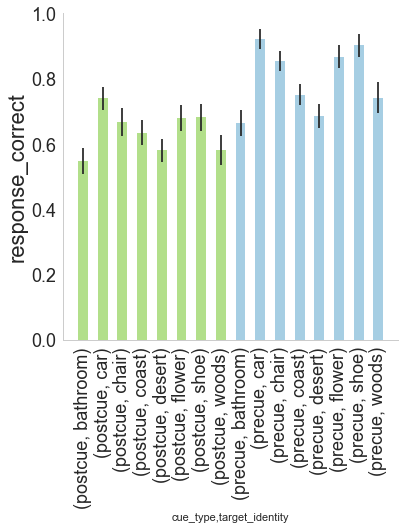

In [65]:
# Define variables 
df_graph = result[(result.cue_type != 'nocue') & (result.cue_type != 'doublecue')]
dataVar = 'response_correct'
iv1 = 'cue_type'
iv2 = 'target_identity'

#Average across subjects by IV 1
g = df_graph.groupby(['subject',iv1,iv2])
a = g[dataVar].mean() #means etc by subject
a = a.reset_index()

print "--------------------------------------------------------------"
print 'Average '+dataVar+'(SD) for '+iv1+':'
c = a.groupby([iv1])
m = c[dataVar].mean().reset_index()
s = c[dataVar].std().reset_index()

for i,row in m.iterrows():
    print  m.loc[i][iv1]+'\t', np.round(m.loc[i][dataVar],4)*100,"("+str(np.round(s.loc[i][dataVar],4)*100)+")"
print "--------------------------------------------------------------"


b, CIs = formatMyEffect(df_graph,dataVar,['subject',iv1, iv2])
plotMyEffect(b, CIs)

In [66]:
## 2 (condA: A, B) x 1 (condB: 1,2,3 [numeric]) repeated measure ANOVA

# Get data into R
r.r_data = a
print r('head(r_data)')

# Define variables 
dataVar = 'response_correct'
iv1 = 'cue_type'
iv2 = 'target_identity'

# Run ANOVA using R syntax with string variable defined above
r('anova <- aov('+dataVar+' ~ '+iv1+'*'+iv2+' + Error(subject/('+iv1+'*'+iv2+')), data=r_data)')
r('myModelSummary <- summary(anova)')
print r('summary(anova)')

# IV 1 info
dfs_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Df'")
fval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'F value'")
pval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Pr(>F)'")

fval_iv1 = np.round(fval_iv1[0],2)
pval_iv1 = np.round(pval_iv1[0],4)

# IV 2 info
dfs_iv2 = r.get("myModelSummary$'Error: subject:"+iv2+"'[[1]]$'Df'")
fval_iv2 = r.get("myModelSummary$'Error: subject:"+iv2+"'[[1]]$'F value'")
pval_iv2 = r.get("myModelSummary$'Error: subject:"+iv2+"'[[1]]$'Pr(>F)'")

fval_iv2 = np.round(fval_iv2[0],2)
pval_iv2 = np.round(pval_iv2[0],4)


# IV 1 * IV 2 interaction info
dfs_int = r.get("myModelSummary$'Error: subject:"+iv1+":"+iv2+"'[[1]]$'Df'")
fval_int = r.get("myModelSummary$'Error: subject:"+iv1+":"+iv2+"'[[1]]$'F value'")
pval_int = r.get("myModelSummary$'Error: subject:"+iv1+":"+iv2+"'[[1]]$'Pr(>F)'")

fval_int = np.round(fval_int[0],2)
pval_int = np.round(pval_int[0],4)


# Eta square for IV 1
sumSq = float(r('summary(anova)[2][[1]][[1]][[2]][1]').split('[1] ')[1])
residualsSumSq = float(r('summary(anova)[2][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_iv1 = np.round(sumSq/(sumSq+residualsSumSq),2)

# Eta square for IV 2
sumSq = float(r('summary(anova)[3][[1]][[1]][[2]][1]').split('[1] ')[1]) 
residualsSumSq = float(r('summary(anova)[3][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_iv2 = np.round(sumSq/(sumSq+residualsSumSq),2)

# Eta square for IV1*IV2 interaction
sumSq = float(r('summary(anova)[4][[1]][[1]][[2]][1]').split('[1] ')[1])
residualsSumSq = float(r('summary(anova)[4][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_int = np.round(sumSq/(sumSq+residualsSumSq),2)



print "--------------------------------------------------------------"
print "\nEffect of",iv1,"on",dataVar
print "F("+str(dfs_iv1[0])+","+str(dfs_iv1[1])+") =",fval_iv1,", p =",pval_iv1,", partial η2 =",etaSquare_iv1
print "\b"

print "\nEffect of",iv2,"on",dataVar
print "F("+str(dfs_iv2[0])+","+str(dfs_iv2[1])+") =",fval_iv2,", p =",pval_iv2,", partial η2 =",etaSquare_iv2
print "\b"

print "\nInteraction between",iv1,"and",iv2,"on",dataVar
print "F("+str(dfs_int[0])+","+str(dfs_int[1])+") =",fval_int,", p =",pval_int,", partial η2 =",etaSquare_int
print "\b"
print "--------------------------------------------------------------"

try({head(r_data)})
  subject cue_type target_identity response_correct
0    s002  postcue        bathroom        0.5263158
1    s002  postcue             car        0.7894737
2    s002  postcue           chair        0.7894737
3    s002  postcue           coast        0.7222222
4    s002  postcue          desert        0.6666667
5    s002  postcue          flower        0.5238095

try({summary(anova)})

Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 24 0.8122 0.03384               

Error: subject:cue_type
          Df Sum Sq Mean Sq F value   Pr(>F)    
cue_type   1 2.5448  2.5448   220.1 1.38e-13 ***
Residuals 24 0.2775  0.0116                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: subject:target_identity
                 Df Sum Sq Mean Sq F value Pr(>F)    
target_identity   7   2.33  0.3329   35.86 <2e-16 ***
Residuals       168   1.56  0.0093                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0

--------------------------------------------------------------
Average response_correct(SD) for cue_type:
postcue	63.87 (7.77)
precue	79.85 (11.47)
--------------------------------------------------------------
CIs: 0.0205283873119 0.0245831855921 0.0260950821297 0.0169047691416


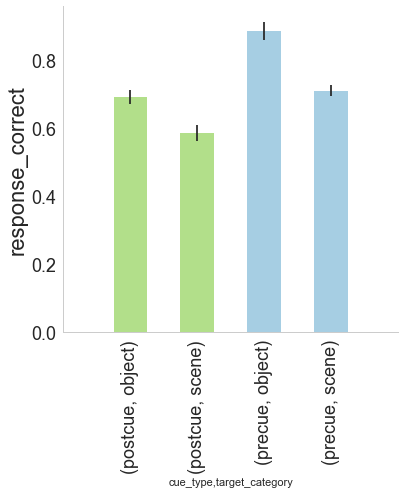

In [67]:
# Define variables 
df_graph = result[(result.cue_type != 'nocue') & (result.cue_type != 'doublecue')]
dataVar = 'response_correct'
iv1 = 'cue_type'
iv2 = 'target_category'

#Average across subjects by IV 1
g = df_graph.groupby(['subject',iv1,iv2])
a = g[dataVar].mean() #means etc by subject
a = a.reset_index()

print "--------------------------------------------------------------"
print 'Average '+dataVar+'(SD) for '+iv1+':'
c = a.groupby([iv1])
m = c[dataVar].mean().reset_index()
s = c[dataVar].std().reset_index()

for i,row in m.iterrows():
    print  m.loc[i][iv1]+'\t', np.round(m.loc[i][dataVar],4)*100,"("+str(np.round(s.loc[i][dataVar],4)*100)+")"
print "--------------------------------------------------------------"


b, CIs = formatMyEffect(df_graph,dataVar,['subject',iv1, iv2])
plotMyEffect(b, CIs)

In [68]:
## 2 (condA: A, B) x 1 (condB: 1,2,3 [numeric]) repeated measure ANOVA

# Get data into R
r.r_data = a
print r('head(r_data)')

# Define variables 
dataVar = 'response_correct'
iv1 = 'cue_type'
iv2 = 'target_category'

# Run ANOVA using R syntax with string variable defined above
r('anova <- aov('+dataVar+' ~ '+iv1+'*'+iv2+' + Error(subject/('+iv1+'*'+iv2+')), data=r_data)')
r('myModelSummary <- summary(anova)')
print r('summary(anova)')

# IV 1 info
dfs_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Df'")
fval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'F value'")
pval_iv1 = r.get("myModelSummary$'Error: subject:"+iv1+"'[[1]]$'Pr(>F)'")

fval_iv1 = np.round(fval_iv1[0],2)
pval_iv1 = np.round(pval_iv1[0],4)

# IV 2 info
dfs_iv2 = r.get("myModelSummary$'Error: subject:"+iv2+"'[[1]]$'Df'")
fval_iv2 = r.get("myModelSummary$'Error: subject:"+iv2+"'[[1]]$'F value'")
pval_iv2 = r.get("myModelSummary$'Error: subject:"+iv2+"'[[1]]$'Pr(>F)'")

fval_iv2 = np.round(fval_iv2[0],2)
pval_iv2 = np.round(pval_iv2[0],4)


# IV 1 * IV 2 interaction info
dfs_int = r.get("myModelSummary$'Error: subject:"+iv1+":"+iv2+"'[[1]]$'Df'")
fval_int = r.get("myModelSummary$'Error: subject:"+iv1+":"+iv2+"'[[1]]$'F value'")
pval_int = r.get("myModelSummary$'Error: subject:"+iv1+":"+iv2+"'[[1]]$'Pr(>F)'")

fval_int = np.round(fval_int[0],2)
pval_int = np.round(pval_int[0],4)


# Eta square for IV 1
sumSq = float(r('summary(anova)[2][[1]][[1]][[2]][1]').split('[1] ')[1])
residualsSumSq = float(r('summary(anova)[2][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_iv1 = np.round(sumSq/(sumSq+residualsSumSq),2)

# Eta square for IV 2
sumSq = float(r('summary(anova)[3][[1]][[1]][[2]][1]').split('[1] ')[1]) 
residualsSumSq = float(r('summary(anova)[3][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_iv2 = np.round(sumSq/(sumSq+residualsSumSq),2)

# Eta square for IV1*IV2 interaction
sumSq = float(r('summary(anova)[4][[1]][[1]][[2]][1]').split('[1] ')[1])
residualsSumSq = float(r('summary(anova)[4][[1]][[1]][[2]][2]').split('[1] ')[1])
etaSquare_int = np.round(sumSq/(sumSq+residualsSumSq),2)



print "--------------------------------------------------------------"
print "\nEffect of",iv1,"on",dataVar
print "F("+str(dfs_iv1[0])+","+str(dfs_iv1[1])+") =",fval_iv1,", p =",pval_iv1,", partial η2 =",etaSquare_iv1
print "\b"

print "\nEffect of",iv2,"on",dataVar
print "F("+str(dfs_iv2[0])+","+str(dfs_iv2[1])+") =",fval_iv2,", p =",pval_iv2,", partial η2 =",etaSquare_iv2
print "\b"

print "\nInteraction between",iv1,"and",iv2,"on",dataVar
print "F("+str(dfs_int[0])+","+str(dfs_int[1])+") =",fval_int,", p =",pval_int,", partial η2 =",etaSquare_int
print "\b"
print "--------------------------------------------------------------"

try({head(r_data)})
  subject cue_type target_category response_correct
0    s002  postcue          object        0.6923077
1    s002  postcue           scene        0.6266667
2    s002   precue          object        0.9358974
3    s002   precue           scene        0.7564103
4    s003  postcue          object        0.7123288
5    s003  postcue           scene        0.5479452

try({summary(anova)})

Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 24 0.2028 0.00845               

Error: subject:cue_type
          Df Sum Sq Mean Sq F value   Pr(>F)    
cue_type   1 0.6380  0.6380   221.7 1.27e-13 ***
Residuals 24 0.0691  0.0029                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: subject:target_category
                Df Sum Sq Mean Sq F value   Pr(>F)    
target_category  1 0.4962  0.4962   144.1 1.24e-11 ***
Residuals       24 0.0826  0.0034                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.